## Cloth Classification Task
8 classes

In [1]:
import os
import torch
import time
import copy
import math
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Visualize Data

In [2]:
train_frame = pd.read_csv('train_label.csv')

# check one photo
img_name = train_frame.iloc[7, 0]
classes = train_frame.iloc[:, 1].as_matrix()
classes = classes.astype('float').reshape(-1, 1)

print('Image name: {}'.format(img_name))
print('classes shape: {}'.format(classes.shape))
print('classes: {}'.format(classes[7]))

Image name: 1002906763_0.jpg
classes shape: (21048, 1)
classes: [ 0.]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


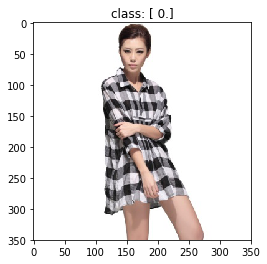

In [3]:
# show images
def show_image(images, label):
    plt.title('class: {}'.format(label))
    plt.imshow(images)
    
show_image(io.imread(os.path.join('./dataset/image/train/', img_name)), classes[7])

## Construct Dataset

In [4]:
class ClothDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, test=False):
        self.train_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.test = test
        
        if self.test:
            imgs = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        else:
            names = self.train_frame.iloc[:, 0]
            imgs = [os.path.join(root_dir, img) for img in names]
    
        self.imgs = imgs
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        if self.test == False:
            label = self.train_frame.iloc[idx, 1]
        else:
            label = -1
            
        image = Image.open(img_path)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Check Dataset(train)

0 0
1 0
2 0
3 0


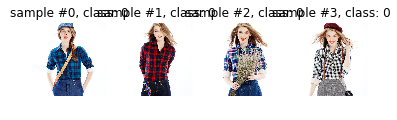

In [5]:
cloth_train_dataset = ClothDataset(csv_file='train_label.csv', root_dir='./dataset/image/train/', test=False)
fig = plt.figure()

for i in range(len(cloth_train_dataset)):
    image, label = cloth_train_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Check Dataset(test)

0 -1
1 -1
2 -1
3 -1


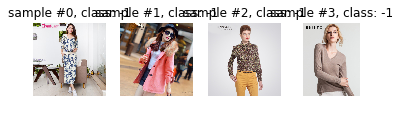

In [6]:
cloth_test_dataset = ClothDataset(csv_file='train_label.csv', root_dir='./dataset/image/test/', test=True)
fig = plt.figure()

for i in range(len(cloth_test_dataset)):
    image, label = cloth_test_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Data Augmentation

In [7]:
# transform1
transform_train = transforms.Compose([
    transforms.Resize((350, 350)),
    # transforms.CenterCrop(350),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform2
transform_test = transforms.Compose([
    transforms.Resize((350,350)),
    # transforms.CenterCrop(350),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Test Transformation

<class 'tuple'>
train_dataset size:  21048
0 torch.Size([3, 350, 350]) 0
1 torch.Size([3, 350, 350]) 0
2 torch.Size([3, 350, 350]) 0
3 torch.Size([3, 350, 350]) 0


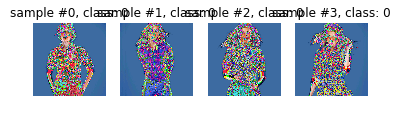

In [8]:
full_dataset = ClothDataset(csv_file='./train_label.csv', root_dir='./dataset/image/train/', test=False, transform=transform_train)
print(type(full_dataset[i]))
print('train_dataset size: ', len(full_dataset))

fig = plt.figure()
for i in range(len(full_dataset)):
    image, label = full_dataset[i]
    print(i, image.shape ,label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    image = transforms.ToPILImage()(image).convert('RGB')
    plt.imshow(image)
    
    if i == 3:
        break

## 划分训练集和校验集

In [9]:
validation_split=0.2
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create data samples and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=5, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=5, sampler=valid_sampler)

print(type(train_dataloader))
print(type(validation_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [10]:
# combine train and validation into one dict
dataloaders = {'train': train_dataloader, 'val': validation_dataloader}
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices)}
print(dataset_sizes['train'])

16839


<class 'tuple'>
0 torch.Size([3, 350, 350]) -1
1 torch.Size([3, 350, 350]) -1
2 torch.Size([3, 350, 350]) -1
3 torch.Size([3, 350, 350]) -1


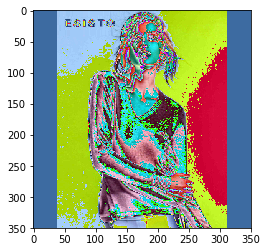

In [11]:
test_dataset = ClothDataset(csv_file='./train_label.csv', root_dir = './dataset/image/test/', test=True,transform= transform_test)
print(type(test_dataset[i]))

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    
    print(i, image.size(), label)
    image = transforms.ToPILImage()(image).convert('RGB')
    plt.imshow(image)
    if i == 3:
        break

### Show Batch Data

<class 'torch.utils.data.dataloader.DataLoader'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([5, 3, 350, 350]) tensor([-1, -1, -1, -1, -1])
1 torch.Size([5, 3, 350, 350]) tensor([-1, -1, -1, -1, -1])
2 torch.Size([5, 3, 350, 350]) tensor([-1, -1, -1, -1, -1])
3 torch.Size([5, 3, 350, 350]) tensor([-1, -1, -1, -1, -1])


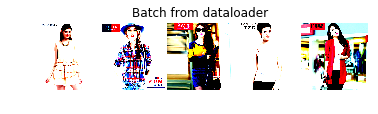

In [12]:
# use DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=False)
print(type(test_dataloader))


def show_cloth_batch(images_batch, labels_batch):
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.title('Batch from dataloader')
        
for i_batch, (images_batch, labels_batch) in enumerate(test_dataloader):
    print(i_batch, images_batch.size(), labels_batch)
    
    if i_batch == 3:
        plt.figure()
        show_cloth_batch(images_batch, labels_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Train Model

In [13]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y)
    plt.title("{} curve".format(title))
    plt.xlabel('epoch')
    plt.ylabel("{}".format(title))
    plt.show()

In [14]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    # measure time
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and testing phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # train mode
            else:
                model.eval() # evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for i_batch, (images_batch, labels_batch) in enumerate(dataloaders[phase]):
                #print(type(sample_batched['image']))
                #print(type(sample_batched['has_cactus']))
                
                inputs = images_batch.to(device, dtype=torch.float)
                labels = labels_batch.to(device, dtype=torch.long)
                
                # labels = labels.resize(labels.size()[0])
                #print(labels.size())
                #print(labels)
                
                # zero gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs.size())
                    #print(labels.size())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistic
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            #print(running_loss)
            #print(running_corrects)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save best model weights up-to-date
                save_model(model, './model/BagNet33_BEST.pt')
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curve(train_loss, 'train_loss')
    show_curve(train_acc, 'train_acc')
    show_curve(val_loss, 'val_loss')
    show_curve(val_acc, 'val_acc')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Define Model

In [16]:
import math
import torch.nn as nn
from torch.utils import model_zoo


model_urls = {
    'bagnet9': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet8-34f4ccd2.pth.tar',
    'bagnet17': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar',
    'bagnet33': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar',
}


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, kernel_size=1):
        super(Bottleneck, self).__init__()
        # print('Creating bottleneck with kernel size {} and stride {} with padding {}'.format(kernel_size, stride, (kernel_size - 1) // 2))
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=stride,
                               padding=0, bias=False) # changed padding from (kernel_size - 1) // 2
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x, **kwargs):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        
        if residual.size(-1) != out.size(-1):
            diff = residual.size(-1) - out.size(-1)
            residual = residual[:,:,:-diff,:-diff]
        
        out += residual
        out = self.relu(out)

        return out


class BagNet(nn.Module):

    def __init__(self, block, layers, strides=[1, 2, 2, 2], kernel3=[0, 0, 0, 0], num_classes=1000, avg_pool=True):
        self.inplanes = 64
        super(BagNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0,
                               bias=False)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.001)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], kernel3=kernel3[0], prefix='layer1')
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], kernel3=kernel3[1], prefix='layer2')
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], kernel3=kernel3[2], prefix='layer3')
        self.layer4 = self._make_layer(block, 512, layers[3], stride=strides[3], kernel3=kernel3[3], prefix='layer4')
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.avg_pool = avg_pool
        self.block = block

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, kernel3=0, prefix=''):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        kernel = 1 if kernel3 == 0 else 3
        layers.append(block(self.inplanes, planes, stride, downsample, kernel_size=kernel))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            kernel = 1 if kernel3 <= i else 3
            layers.append(block(self.inplanes, planes, kernel_size=kernel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.avg_pool:
            x = nn.AvgPool2d(x.size()[2], stride=1)(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
        else:
            x = x.permute(0,2,3,1)
            x = self.fc(x)

        return x

def create_bagnet33(pretrained=False, strides=[2, 2, 2, 1], **kwargs):
    """Constructs a Bagnet-33 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = BagNet(Bottleneck, [3, 4, 6, 3], strides=strides, kernel3=[1,1,1,1], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['bagnet33']))
    return model

def create_bagnet17(pretrained=False, strides=[2, 2, 2, 1], **kwargs):
    """Constructs a Bagnet-17 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = BagNet(Bottleneck, [3, 4, 6, 3], strides=strides, kernel3=[1,1,1,0], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['bagnet17']))
    return model

def create_bagnet9(pretrained=False, strides=[2, 2, 2, 1], **kwargs):
    """Constructs a Bagnet-9 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = BagNet(Bottleneck, [3, 4, 6, 3], strides=strides, kernel3=[1,1,0,0], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['bagnet9']))
    return model

## Set Hyper-parameter

In [17]:
# Set model
bagnet33 = create_bagnet33(num_classes=8)
print(bagnet33)

# Set Parameters
lr = 0.001
momentum = 0.9
step_size=10
gamma=0.1
num_epochs=30

# Set GPU
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

BagNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05

## BagNet33

In [18]:
model = bagnet33.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/29
----------
train Loss: 1.9782 Acc: 0.2517
val Loss: 2.0534 Acc: 0.2321

Epoch 1/29
----------
train Loss: 1.9296 Acc: 0.2629
val Loss: 1.9185 Acc: 0.2811

Epoch 2/29
----------
train Loss: 1.9140 Acc: 0.2705
val Loss: 1.9044 Acc: 0.2960

Epoch 3/29
----------
train Loss: 1.8890 Acc: 0.2806
val Loss: 1.8646 Acc: 0.3034

Epoch 4/29
----------
train Loss: 1.8497 Acc: 0.3010
val Loss: 2.0731 Acc: 0.3029

Epoch 5/29
----------
train Loss: 1.7483 Acc: 0.3355
val Loss: 2.3195 Acc: 0.3535

Epoch 6/29
----------
train Loss: 1.6732 Acc: 0.3646
val Loss: 1.7649 Acc: 0.3896

Epoch 7/29
----------
train Loss: 1.6087 Acc: 0.3954
val Loss: 1.5837 Acc: 0.4246

Epoch 8/29
----------
train Loss: 1.5396 Acc: 0.4241
val Loss: 1.5908 Acc: 0.4324

Epoch 9/29
----------
train Loss: 1.4760 Acc: 0.4470
val Loss: 1.4789 Acc: 0.4680

Epoch 10/29
----------
train Loss: 1.3455 Acc: 0.4990
val Loss: 1.3772 Acc: 0.5239

Epoch 11/29
----------
train Loss: 1.3101 Acc: 0.5107
val Loss: 1.3918 Acc: 0.5225

Ep

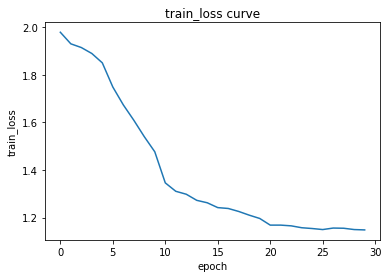

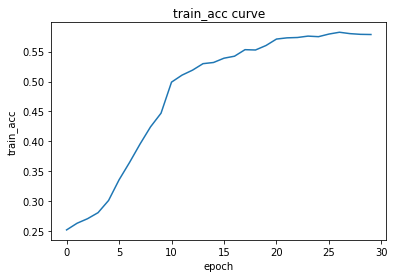

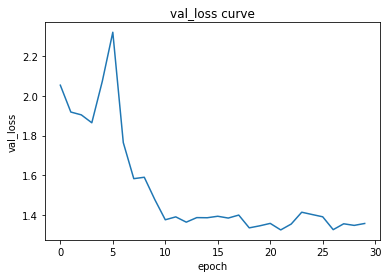

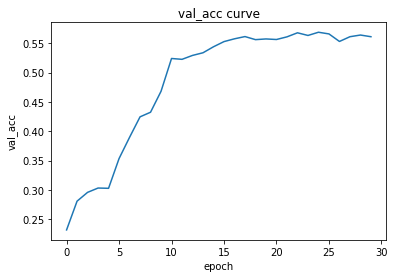

In [19]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

In [20]:
bagnet33 = create_bagnet33(num_classes=8)

checkpoint = torch.load('./model/BagNet33_BEST.pt')
bagnet33.load_state_dict(checkpoint)

# Set Parameters
lr = 0.001
momentum = 0.9
step_size=20
gamma=0.1
num_epochs=30

# Set GPU
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


In [21]:
model = bagnet33.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/29
----------
train Loss: 1.3385 Acc: 0.5073
val Loss: 1.4575 Acc: 0.5101

Epoch 1/29
----------
train Loss: 1.3072 Acc: 0.5140
val Loss: 1.3547 Acc: 0.5272

Epoch 2/29
----------
train Loss: 1.2582 Acc: 0.5393
val Loss: 1.3043 Acc: 0.5362

Epoch 3/29
----------
train Loss: 1.2017 Acc: 0.5594
val Loss: 1.2814 Acc: 0.5859

Epoch 4/29
----------
train Loss: 1.1619 Acc: 0.5760
val Loss: 1.3328 Acc: 0.5436

Epoch 5/29
----------
train Loss: 1.1113 Acc: 0.5947
val Loss: 1.5203 Acc: 0.5923

Epoch 6/29
----------
train Loss: 1.0723 Acc: 0.6122
val Loss: 1.3832 Acc: 0.5866

Epoch 7/29
----------
train Loss: 1.0238 Acc: 0.6303
val Loss: 1.2965 Acc: 0.6246

Epoch 8/29
----------
train Loss: 0.9864 Acc: 0.6493
val Loss: 1.1490 Acc: 0.6256

Epoch 9/29
----------
train Loss: 0.9470 Acc: 0.6597
val Loss: 1.1804 Acc: 0.6156

Epoch 10/29
----------
train Loss: 0.9079 Acc: 0.6746
val Loss: 1.1272 Acc: 0.6493

Epoch 11/29
----------
train Loss: 0.8722 Acc: 0.6928
val Loss: 1.1029 Acc: 0.6503

Ep

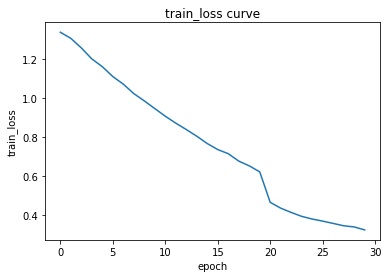

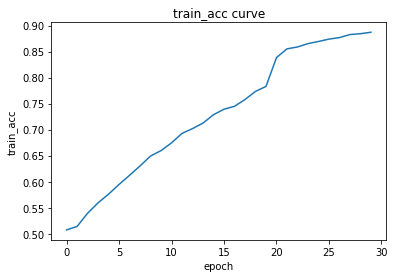

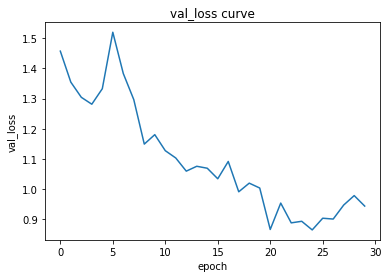

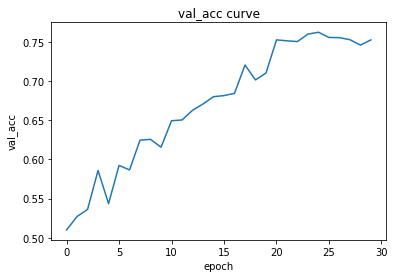

In [22]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

In [26]:
bagnet33 = create_bagnet33(num_classes=8)

checkpoint = torch.load('./model/BagNet33_BEST.pt')
bagnet33.load_state_dict(checkpoint)

# Set Parameters
lr = 0.0001
momentum = 0.9
step_size=5
gamma=0.1
num_epochs=30

# Set GPU
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


In [27]:
model = bagnet33.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/29
----------
train Loss: 0.3667 Acc: 0.8743
val Loss: 0.8988 Acc: 0.7451

Epoch 1/29
----------
train Loss: 0.3559 Acc: 0.8796
val Loss: 0.9389 Acc: 0.7529

Epoch 2/29
----------
train Loss: 0.3484 Acc: 0.8783
val Loss: 0.8889 Acc: 0.7565

Epoch 3/29
----------
train Loss: 0.3339 Acc: 0.8843
val Loss: 0.8986 Acc: 0.7577

Epoch 4/29
----------
train Loss: 0.3304 Acc: 0.8869
val Loss: 0.8628 Acc: 0.7548

Epoch 5/29
----------
train Loss: 0.3081 Acc: 0.8956
val Loss: 0.8538 Acc: 0.7627

Epoch 6/29
----------
train Loss: 0.2998 Acc: 0.8998
val Loss: 0.9338 Acc: 0.7598

Epoch 7/29
----------
train Loss: 0.2979 Acc: 0.9013
val Loss: 0.9257 Acc: 0.7622

Epoch 8/29
----------
train Loss: 0.2912 Acc: 0.9013
val Loss: 0.9596 Acc: 0.7515

Epoch 9/29
----------
train Loss: 0.2908 Acc: 0.9013
val Loss: 0.9121 Acc: 0.7619

Epoch 10/29
----------
train Loss: 0.2881 Acc: 0.9024
val Loss: 0.8919 Acc: 0.7477

Epoch 11/29
----------
train Loss: 0.2888 Acc: 0.9024
val Loss: 0.9830 Acc: 0.7567

Ep

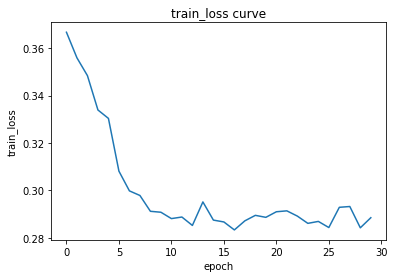

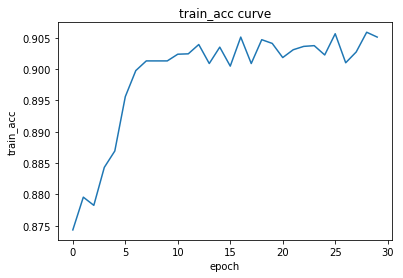

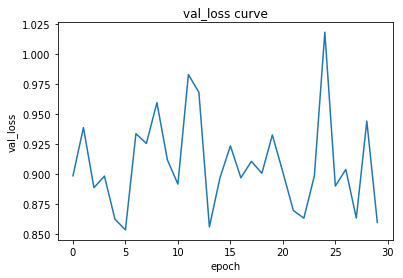

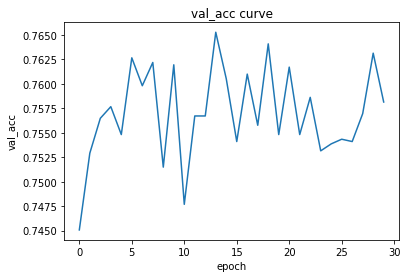

In [28]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

In [18]:
# Set model
bagnet33 = create_bagnet33(num_classes=8)
print(bagnet33)

# Set Parameters
lr = 0.001
momentum = 0.9
step_size=35
gamma=0.1
num_epochs=45

# Set GPU
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

BagNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05

In [19]:
model = bagnet33.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/44
----------
train Loss: 1.9598 Acc: 0.2550
val Loss: 1.9226 Acc: 0.2775

Epoch 1/44
----------
train Loss: 1.9212 Acc: 0.2673
val Loss: 1.8862 Acc: 0.2723

Epoch 2/44
----------
train Loss: 1.8707 Acc: 0.2804
val Loss: 1.8696 Acc: 0.3153

Epoch 3/44
----------
train Loss: 1.7659 Acc: 0.3302
val Loss: 1.7386 Acc: 0.3547

Epoch 4/44
----------
train Loss: 1.6860 Acc: 0.3602
val Loss: 1.9223 Acc: 0.3830

Epoch 5/44
----------
train Loss: 1.6361 Acc: 0.3763
val Loss: 1.6770 Acc: 0.3851

Epoch 6/44
----------
train Loss: 1.5577 Acc: 0.4123
val Loss: 1.5801 Acc: 0.4669

Epoch 7/44
----------
train Loss: 1.4851 Acc: 0.4395
val Loss: 1.4934 Acc: 0.5013

Epoch 8/44
----------
train Loss: 1.4204 Acc: 0.4680
val Loss: 1.4660 Acc: 0.4780

Epoch 9/44
----------
train Loss: 1.3748 Acc: 0.4886
val Loss: 1.4438 Acc: 0.4825

Epoch 10/44
----------
train Loss: 1.3326 Acc: 0.5028
val Loss: 1.3890 Acc: 0.4985

Epoch 11/44
----------
train Loss: 1.2835 Acc: 0.5206
val Loss: 1.5432 Acc: 0.4958

Ep

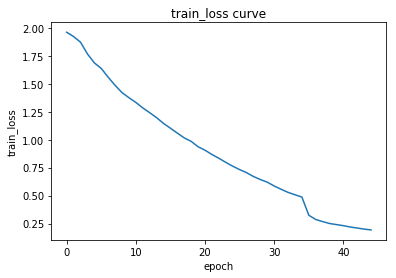

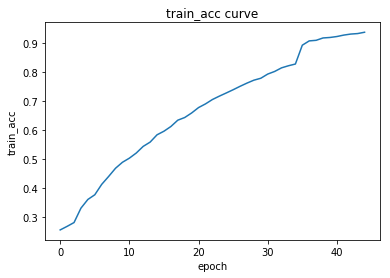

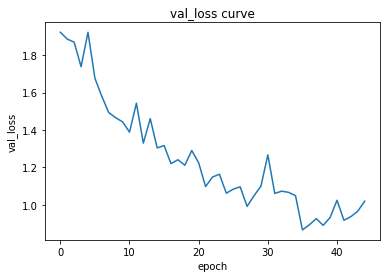

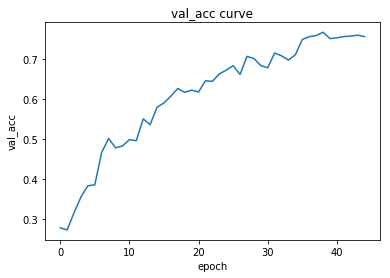

In [20]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

## Visualize Model Prediction

In [49]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [50]:
# Visualize the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i_batch, (images_batch, labels_batch) in enumerate(dataloaders['val']):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                # show images
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predict: {}'.format(preds[j].item()))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

## Set Hyper-parameter

## Predict

In [54]:
def predict(model, test_dataloader):
    result = []
    with torch.no_grad():
         for i_batch, (images_batch, labels_batch) in enumerate(test_dataloader):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            # print(type(preds))
            # print(preds)
            preds_np = preds.cpu().numpy()
            # print(preds_np)
            result = np.append(result, preds_np)
            
            # print(result)
            
            if (i_batch == 2000):
                print('2000 batches')
            elif i_batch == 4000:
                print('4000 batches')
    
    return result

In [55]:
# Set Model
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(51200, 8)

checkpoint = torch.load('./model/resnet50_adam_350_BEST.pt')
model_resnet50.load_state_dict(checkpoint)

# Set GPU
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
model = model_resnet50.to(device)

cuda:3


In [56]:
result = predict(model, test_dataloader)

In [57]:
print(type(result))
print(result.shape)

<class 'numpy.ndarray'>
(4500,)


In [58]:
img_idx = os.listdir('./dataset/image/test/')
print(img_idx)
img_idx = prediction.iloc[:, 0]
print(img_idx)

['1257194670_0.jpg', '1331669067_0.jpg', '1030031690_0.jpg', '1042079939_0.jpg', '1392549927_0.jpg', '1219369112_0.jpg', '1074414124_0.jpg', '1022435684_0.jpg', '1382318481_0.jpg', '1109736123_0.jpg', '1049622193_0.jpg', '1029862130_0.jpg', '1445565607_0.jpg', '1454956234_0.jpg', '1004558638_0.jpg', '1477572864_0.jpg', '1797314050_0.jpg', '1054664399_0.jpg', '1087983100_0.jpg', '1156694115_0.jpg', '1187166366_0.jpg', '1344869062_0.jpg', '1411108444_0.jpg', '1500368012_0.jpg', '1111112171_0.jpg', '1166941378_0.jpg', '1246367092_0.jpg', '1350177495_0.jpg', '10056013380_0.jpg', '1121574657_0.jpg', '1303850620_0.jpg', '1102712669_0.jpg', '1205757170_0.jpg', '1036523237_0.jpg', '1324702294_0.jpg', '1392129959_0.jpg', '1359907332_0.jpg', '1478486268_0.jpg', '1389461157_0.jpg', '1095502819_0.jpg', '1722904135_0.jpg', '1029194300_0.jpg', '1539907962_0.jpg', '1409573292_0.jpg', '1485571905_0.jpg', '1146838255_0.jpg', '1101318621_0.jpg', '1314149812_0.jpg', '1146567724_0.jpg', '1262301524_0.jpg'

NameError: name 'prediction' is not defined

In [59]:
classify_result = pd.DataFrame({'Image': img_idx, 'Cloth_label': result.astype(np.int32)})
print(classify_result)

                  Image  Cloth_label
0      1257194670_0.jpg            5
1      1331669067_0.jpg            6
2      1030031690_0.jpg            0
3      1042079939_0.jpg            7
4      1392549927_0.jpg            3
5      1219369112_0.jpg            7
6      1074414124_0.jpg            0
7      1022435684_0.jpg            5
8      1382318481_0.jpg            7
9      1109736123_0.jpg            5
10     1049622193_0.jpg            3
11     1029862130_0.jpg            2
12     1445565607_0.jpg            4
13     1454956234_0.jpg            3
14     1004558638_0.jpg            1
15     1477572864_0.jpg            5
16     1797314050_0.jpg            0
17     1054664399_0.jpg            5
18     1087983100_0.jpg            4
19     1156694115_0.jpg            5
20     1187166366_0.jpg            3
21     1344869062_0.jpg            3
22     1411108444_0.jpg            3
23     1500368012_0.jpg            5
24     1111112171_0.jpg            1
25     1166941378_0.jpg            1
2

In [60]:
classify_result.to_csv('./result/result_resnet50_350_new.csv', index=False)